## Librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier, plot_tree,  _tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer

from joblib import Parallel, delayed

from time import time

import duckdb
%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:
import time

import optuna
from optuna.visualization import plot_param_importances, plot_contour,  plot_slice, plot_optimization_history

import plotly.express as px


In [2]:
semillas =[ 400009,  500009,  600011,  700021,  800021]

In [3]:
# import pandas as pd



# import numpy as np



# df_parallel = pd.read_csv(r"C:\Users\Admin\Documents\1_Notebook\1_Estudio\1 UBA Maestría DS\1_Especialización\1_Segundo Semestre\DMEyF\datasets\competencia_01_crudo.csv")



# start_time = time.time()

# # Crear la columna clase_ternaria usando la columna 'foto_mes' basada en la presencia real

# df_ternaria= duckdb.query('''

#     WITH siguiente_mes AS (

#         SELECT

#             numero_de_cliente,

#             foto_mes,

#             -- Obtener los meses siguientes en los que el cliente está presente

#             LEAD(foto_mes, 1) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes) AS foto_mes_proximo1,

#             LEAD(foto_mes, 2) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes) AS foto_mes_proximo2

#         FROM df_parallel

#     )

#     SELECT

#         numero_de_cliente,

#         foto_mes,

#         CASE

#             -- Si el cliente está en los dos meses consecutivos siguientes

#             WHEN foto_mes_proximo1 = foto_mes + 1 AND foto_mes_proximo2 = foto_mes + 2 THEN 'CONTINUA'

#             -- Si el cliente no está en el siguiente mes

#             WHEN foto_mes_proximo1 IS NULL OR foto_mes_proximo1 <> foto_mes + 1 THEN 'BAJA+1'

#             -- Si el cliente está en el siguiente mes pero no en el segundo mes consecutivo

#             WHEN foto_mes_proximo1 = foto_mes + 1 AND (foto_mes_proximo2 IS NULL OR foto_mes_proximo2 <> foto_mes + 2) THEN 'BAJA+2'

#             ELSE NULL

#         END AS clase_ternaria

#     FROM siguiente_mes

# #     ORDER BY numero_de_cliente, foto_mes

# # ''')

# # # Seleccionar solo las columnas necesarias para el merge
# # df_ternaria = df_ternaria.to_df()
# # df_ternaria = df_ternaria[['numero_de_cliente', 'foto_mes', 'clase_ternaria']]

# # # Realizar el merge
# # df_parallel = df_parallel.merge(df_ternaria, on=['numero_de_cliente', 'foto_mes'], how='left')


In [4]:
df_train = pd.read_csv(r"C:\Users\Admin\Documents\1_Notebook\1_Estudio\1 UBA Maestría DS\1_Especialización\1_Segundo Semestre\DMEyF\Python\competencia_01.csv", index_col=0)
con = duckdb.connect(database=':memory:')
con.register('df_train', df_train)

In [5]:
df_dict = pd.read_excel(r"C:\Users\Admin\Documents\1_Notebook\1_Estudio\1 UBA Maestría DS\1_Especialización\1_Segundo Semestre\DMEyF\Python\DiccionarioDatos_2024.xlsx", index_col=0)

In [6]:
cantidad_tarjetas_Visa = df_train.groupby('Visa_status').agg(cantidad = ('Visa_status','count')).reset_index()
cantidad_tarjetas_Visa = cantidad_tarjetas_Visa.set_index('Visa_status')

cantidad_tarjetas_Master = df_train.groupby('Master_status').agg(cantidad = ('Master_status','count')).reset_index()
cantidad_tarjetas_Master['cantidad'].sum()

880627

In [7]:
cantidad_tarjetas_Master

,Master_status,cantidad
0,0.0,878059
1,6.0,148
2,7.0,1186
3,9.0,1234


In [8]:
cantidad_tarjetas_Visa

,cantidad
Visa_status,
0.0,930271
6.0,177
7.0,1394
9.0,1266


In [9]:
df_dict.columns

Index(['campo', 'unidad', 'Significado'], dtype='object')

In [10]:
df_dict = df_dict.set_index('campo')

# Analisis exploratorio 

In [11]:
df_train.columns

Index(['numero_de_cliente', 'foto_mes', 'active_quarter', 'cliente_vip',
       'internet', 'cliente_edad', 'cliente_antiguedad', 'mrentabilidad',
       'mrentabilidad_annual', 'mcomisiones',
       ...
       'Visa_fultimo_cierre', 'Visa_mpagado', 'Visa_mpagospesos',
       'Visa_mpagosdolares', 'Visa_fechaalta', 'Visa_mconsumototal',
       'Visa_cconsumos', 'Visa_cadelantosefectivo', 'Visa_mpagominimo',
       'clase_ternaria'],
      dtype='object', length=155)

In [12]:
df_e = df_train[df_train['clase_ternaria']=='BAJA+2']

### Feature Engineering

In [13]:
%%sql


SELECT 
    numero_de_cliente,
    mpayroll,
    mcuentas_saldo,
    (IFNULL(mpayroll, 0) - IFNULL(mcuentas_saldo, 0)) / NULLIF(ctrx_quarter, 0) AS intensidad_gasto
FROM df_train;

,numero_de_cliente,mpayroll,mcuentas_saldo,intensidad_gasto
0,249221109,140760.00,71493.86,417.265904
1,249221468,0.00,74024.15,-510.511379
2,249223005,115229.65,-1467.41,641.192637
3,249228180,0.00,5.05,-0.202000
4,249232117,0.00,31576.35,-986.760937
...,...,...,...,...
981941,1598444941,23460.00,0.00,11730.000000
981942,1598471047,0.00,91576.57,-18315.314000
981943,1598515897,0.00,71850.94,-35925.470000
981944,1598517059,116570.62,0.00,58285.310000


In [14]:
%%sql
CREATE OR REPLACE TABLE df_train AS
SELECT 
    *,
    (IFNULL(mpayroll, 0) - IFNULL(mcuentas_saldo, 0)) / NULLIF(ctrx_quarter, 0) AS intensidad_gasto
FROM df_train;

,Success


In [15]:
%%sql 
create or replace table df_train as
select 
    *,
    (IFNULL(visa_msaldototal, 0) + IFNULL(master_msaldototal, 0)) as t_saldo_total
from df_train




,Success


In [16]:
%%sql 
create or replace table df_train as
select 
    *,
    (ifnull(Master_mconsumototal,0) + ifnull(Visa_mconsumototal,0)) as t_consumo_total
from df_train


,Success


In [17]:
%%sql
create or replace table df_train as
select
    *,
    (case when visa_status = 0 then True end) as T_Visa_normal,
    (case when Master_status = 0 then True end) as T_Master_normal
from df_train

,Success


In [18]:
result = %sql SELECT * FROM df_train
df_train = pd.DataFrame(result)

In [19]:
df_matrix = df_train[df_train['foto_mes']==202104]
Xtrain = df_matrix
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)
Xtrain = Xtrain.drop("clase_ternaria", axis=1)


In [20]:
np.random.seed(semillas[0])


continua_sample = ytrain[ytrain == 0].sample(2000).index
bajas_1_2 = ytrain[ytrain == 1].index
rf_index = continua_sample.union(bajas_1_2)

Xtrain_rf = Xtrain.loc[rf_index]
ytrain_rf = ytrain.loc[rf_index]

In [21]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
Xtrain_rf_imp = imp_mean.fit_transform(Xtrain_rf)

model = RandomForestClassifier(n_estimators=100, max_features=20, min_samples_leaf=400, random_state=semillas[0] )
model.fit(Xtrain_rf_imp, ytrain_rf)

RandomForestClassifier(max_features=20, min_samples_leaf=400,
                       random_state=400009)

In [22]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat

md = distanceMatrix(model, Xtrain_rf_imp)

c:\Users\Admin\.conda\envs\datascience\Lib\site-packages\umap\umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
c:\Users\Admin\.conda\envs\datascience\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


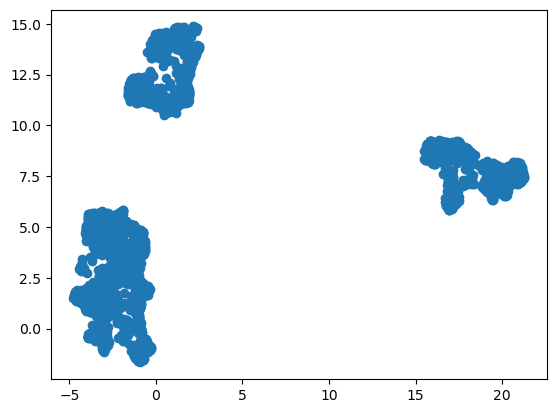

In [23]:
embedding_rf = UMAP(
  n_components=2,
  n_neighbors=50,
  metric="precomputed",
  random_state= semillas[0],
).fit_transform(md)

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

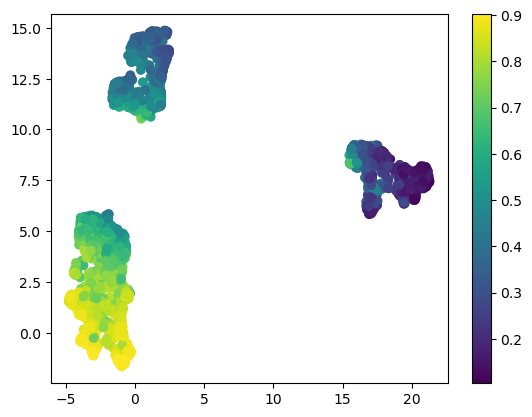

In [24]:
class_index = np.where(model.classes_ == 1)[0]
prob_baja = model.predict_proba(Xtrain_rf_imp)[:,class_index]

plt.scatter(embedding_rf[:,0], embedding_rf[:,1], c=prob_baja)
plt.colorbar()
plt.show()

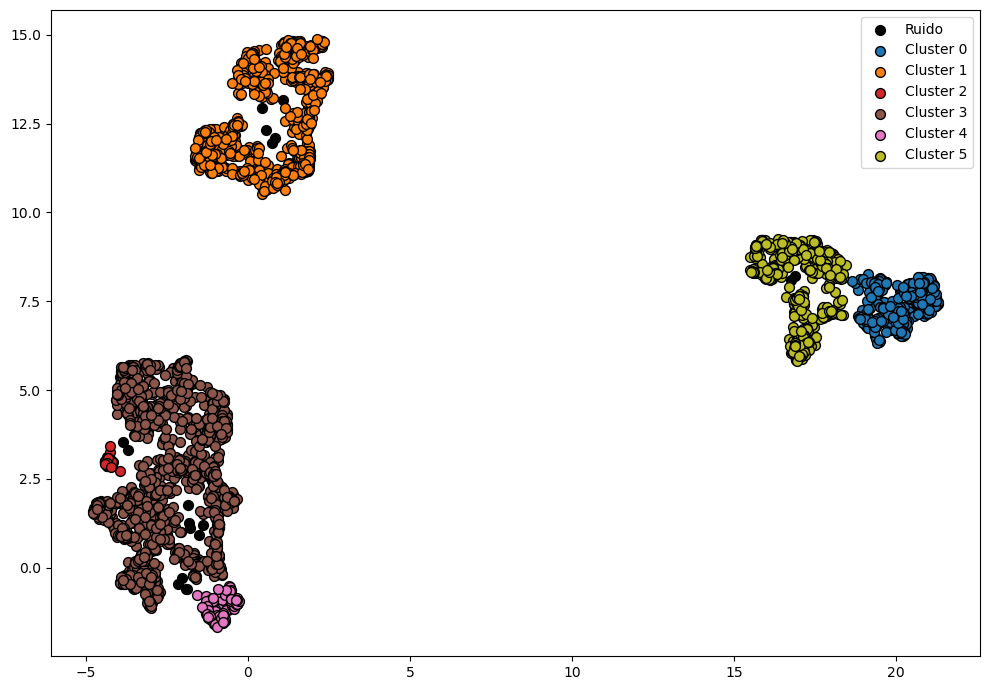

In [25]:
hdb = DBSCAN(eps=0.3)
y = hdb.fit(embedding_rf)


labels_unique = np.unique(y.labels_)
colors = plt.get_cmap('tab10')(np.linspace(0, 1, len(labels_unique)))


plt.figure(figsize=(10, 7))
for label in labels_unique:
    if label == -1:
        
        color = 'k'
        label_name = 'Ruido'
    else:
        color = colors[label % len(colors)]
        label_name = f'Cluster {label}'
    plt.scatter(embedding_rf[y.labels_ == label, 0], embedding_rf[y.labels_ == label, 1], 
                color=color, label=label_name, edgecolor='k', s=50)


plt.legend()
plt.tight_layout()
plt.show()


# 1 = Naraja / 3 = Marron, 4= rosa, 5 = amarillo, 0 = celeste,

#### Análisis de los clusters

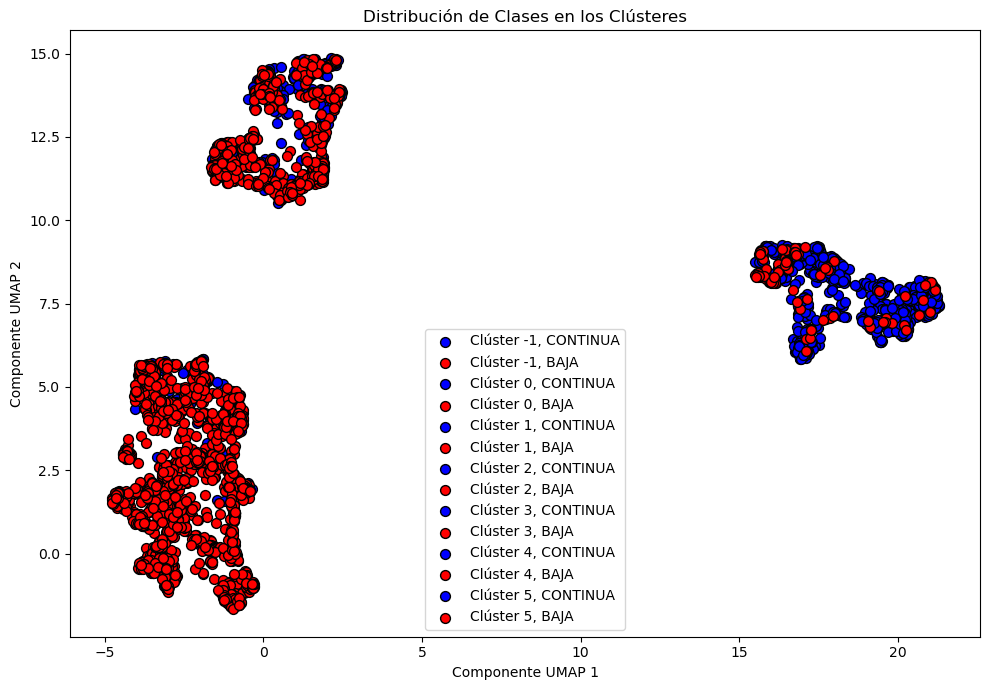

In [26]:

# Crear un mapa de colores para las clases
class_colors = {0: 'blue', 1: 'red'}
class_names = {0: 'CONTINUA', 1: 'BAJA'}

plt.figure(figsize=(10, 7))

# Obtener etiquetas de clúster únicas
labels_unique = np.unique(y.labels_)
colors = plt.get_cmap('tab10')(np.linspace(0, 1, len(labels_unique)))

for label in labels_unique:
    # Indices de los puntos en este clúster
    idx = y.labels_ == label
    # Obtener las etiquetas de clase de estos puntos
    classes_in_cluster = ytrain_rf.values[idx]
    # Colorear puntos según su clase
    for class_value in [0, 1]:
        idx_class = idx & (ytrain_rf.values == class_value)
        if np.any(idx_class):
            plt.scatter(
                embedding_rf[idx_class, 0],
                embedding_rf[idx_class, 1],
                color=class_colors[class_value],
                label=f'Clúster {label}, {class_names[class_value]}',
                edgecolor='k',
                s=50
            )

# Eliminar duplicados en la leyenda
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel('Componente UMAP 1')
plt.ylabel('Componente UMAP 2')
plt.title('Distribución de Clases en los Clústeres')
plt.tight_layout()
plt.show()

In [27]:
pd.Series(y.labels_).value_counts()

 3    1640
 1    1114
 5     626
 0     544
 4     186
 2      48
-1      18
Name: count, dtype: int64

In [28]:
df_embedding = pd.DataFrame(embedding_rf, columns=['embedding_1', 'embedding_2'])
df_embedding['cluster'] = y.labels_

clusters = df_embedding['cluster'].unique()

important_features_by_cluster = {}

for cluster in clusters:
  y_binary = (df_embedding['cluster'] == cluster).astype(int)

  model = RandomForestClassifier(random_state=semillas[0])
  model.fit(Xtrain_rf_imp, y_binary)

  importances = model.feature_importances_
  feature_names = Xtrain_rf.columns

  indices = np.argsort(importances)[::-1]
  important_features_by_cluster[cluster] = [feature_names[i] for i in indices]

In [29]:
for cluster, features in important_features_by_cluster.items():
  print(f"Cluster {cluster} vs. Resto:")
  for feature in features[:5]:
    print(f"  - {feature}")
    
    
    
# 1 = Naraja / 3 = Marron, 4= rosa, 5 = amarillo, 0 = celeste,


Cluster 0 vs. Resto:
  - mpayroll
  - cpayroll_trx
  - mcuentas_saldo
  - Visa_msaldopesos
  - Visa_msaldototal
Cluster 1 vs. Resto:
  - ctrx_quarter
  - cpayroll_trx
  - mpayroll
  - intensidad_gasto
  - ccomisiones_mantenimiento
Cluster 2 vs. Resto:
  - Visa_mpagominimo
  - Visa_delinquency
  - Visa_msaldototal
  - Visa_Finiciomora
  - Visa_status
Cluster 3 vs. Resto:
  - ctrx_quarter
  - mautoservicio
  - mpayroll
  - mtransferencias_emitidas
  - ctarjeta_debito_transacciones
Cluster 4 vs. Resto:
  - ccomisiones_otras
  - mcomisiones_otras
  - mcomisiones
  - cproductos
  - ctrx_quarter
Cluster 5 vs. Resto:
  - mpayroll
  - cpayroll_trx
  - mcuentas_saldo
  - intensidad_gasto
  - Visa_msaldopesos
Cluster -1 vs. Resto:
  - numero_de_cliente
  - mpasivos_margen
  - mrentabilidad
  - mactivos_margen
  - mcuenta_corriente


c:\Users\Admin\.conda\envs\datascience\Lib\site-packages\seaborn\axisgrid.py:186: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


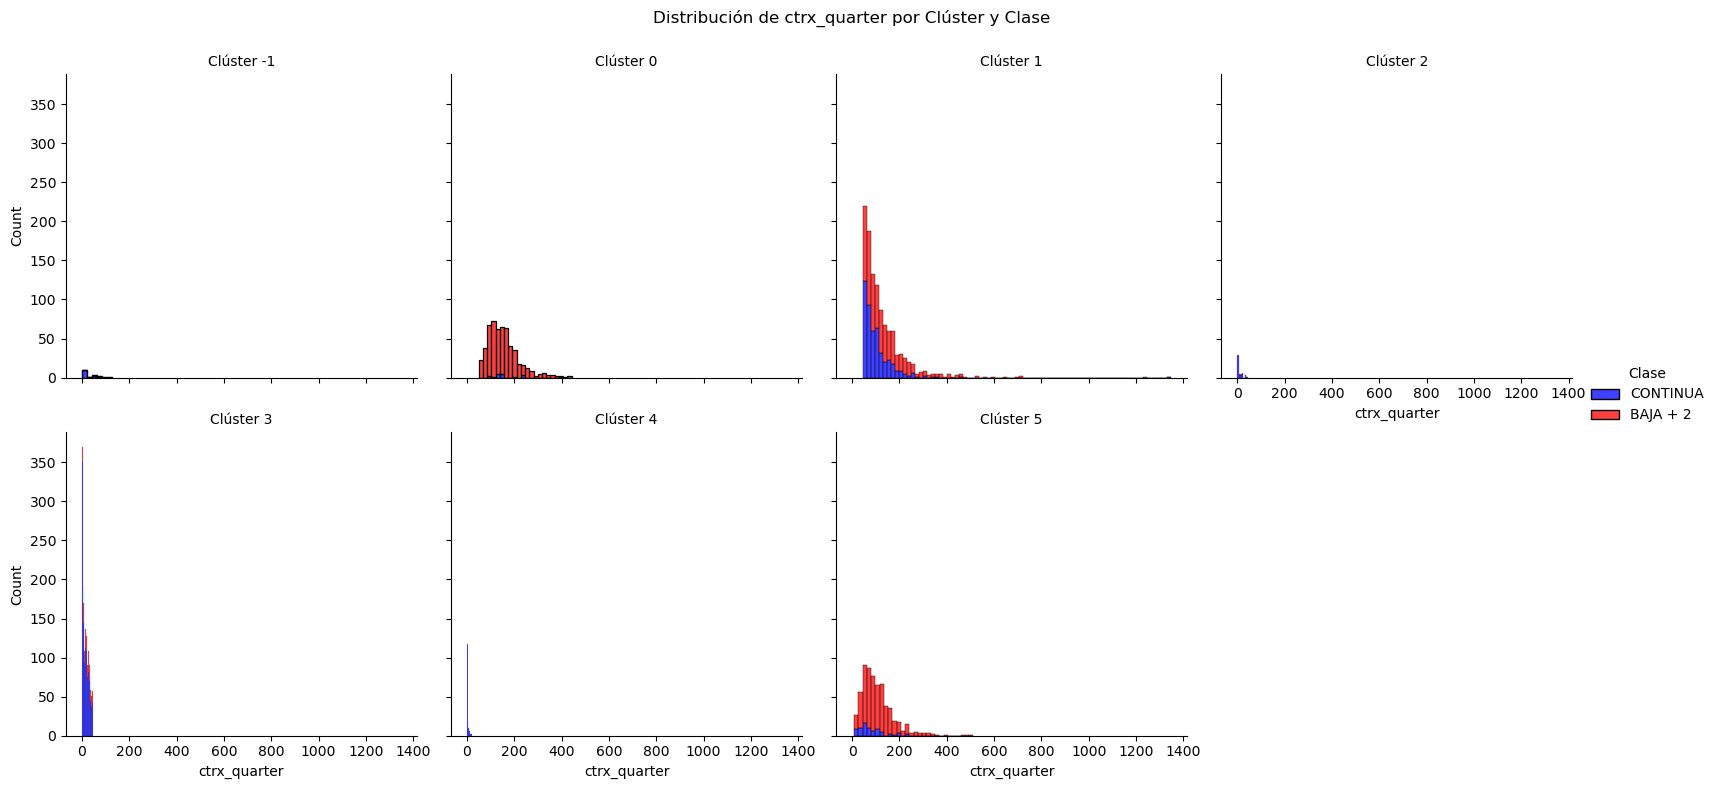

c:\Users\Admin\.conda\envs\datascience\Lib\site-packages\seaborn\axisgrid.py:186: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


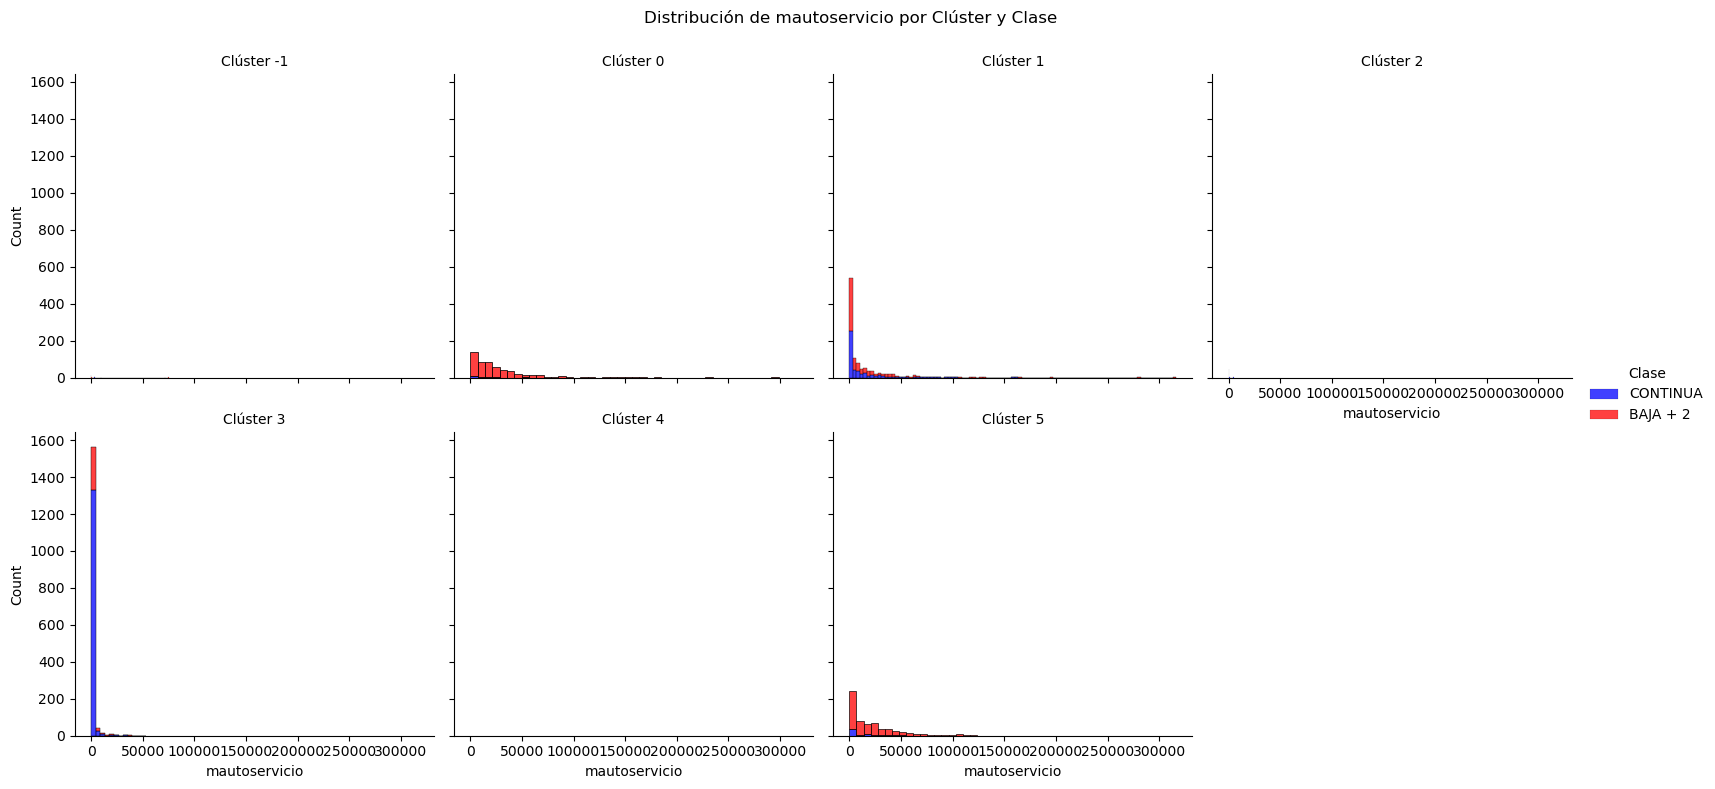

c:\Users\Admin\.conda\envs\datascience\Lib\site-packages\seaborn\axisgrid.py:186: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


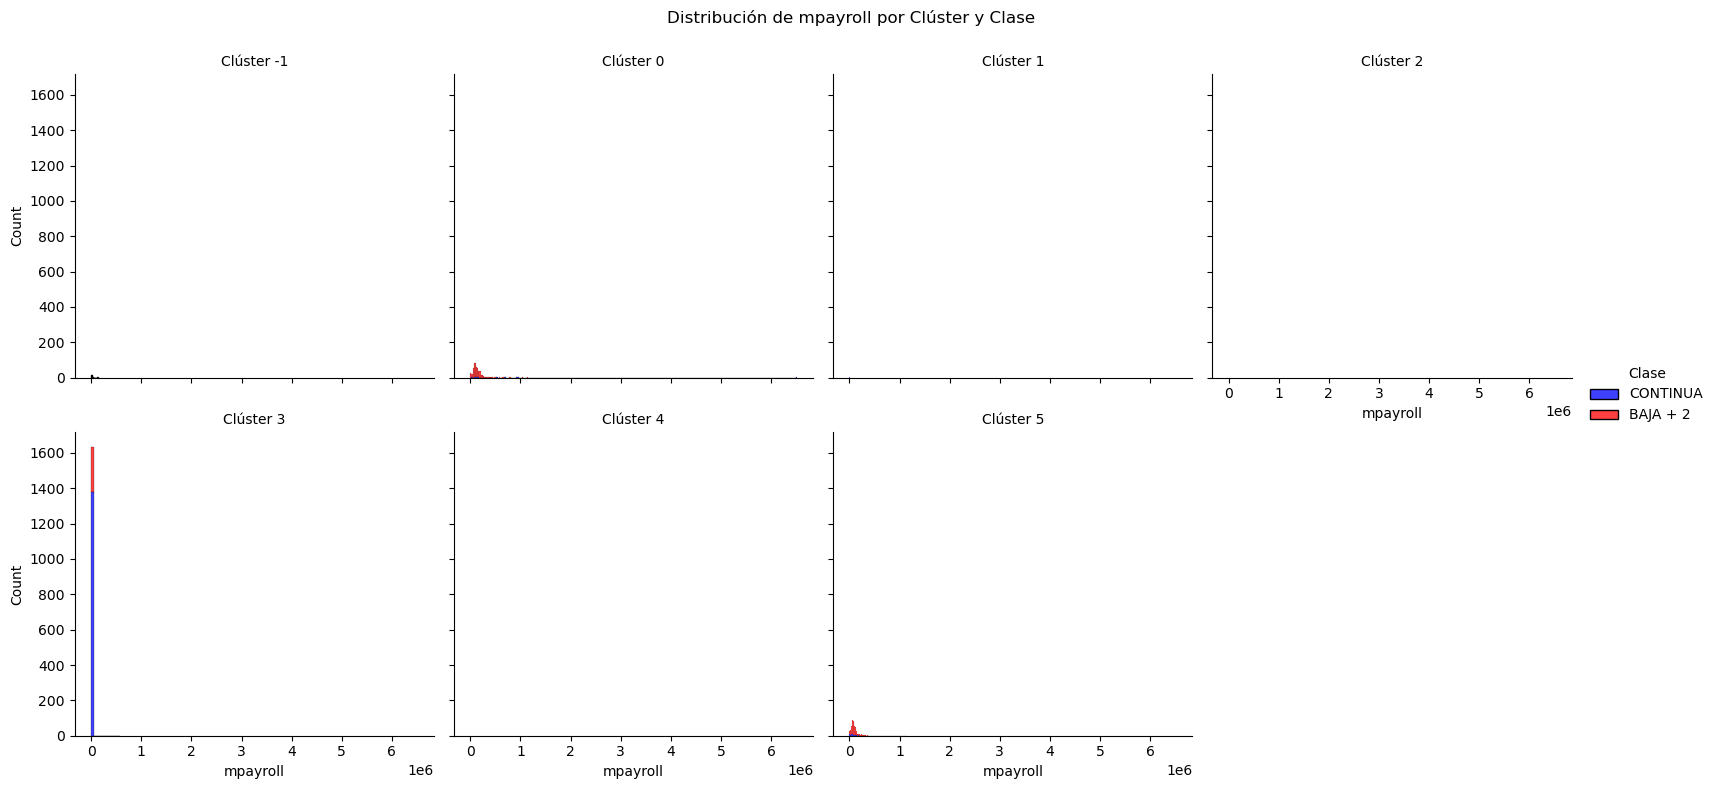

c:\Users\Admin\.conda\envs\datascience\Lib\site-packages\seaborn\axisgrid.py:186: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


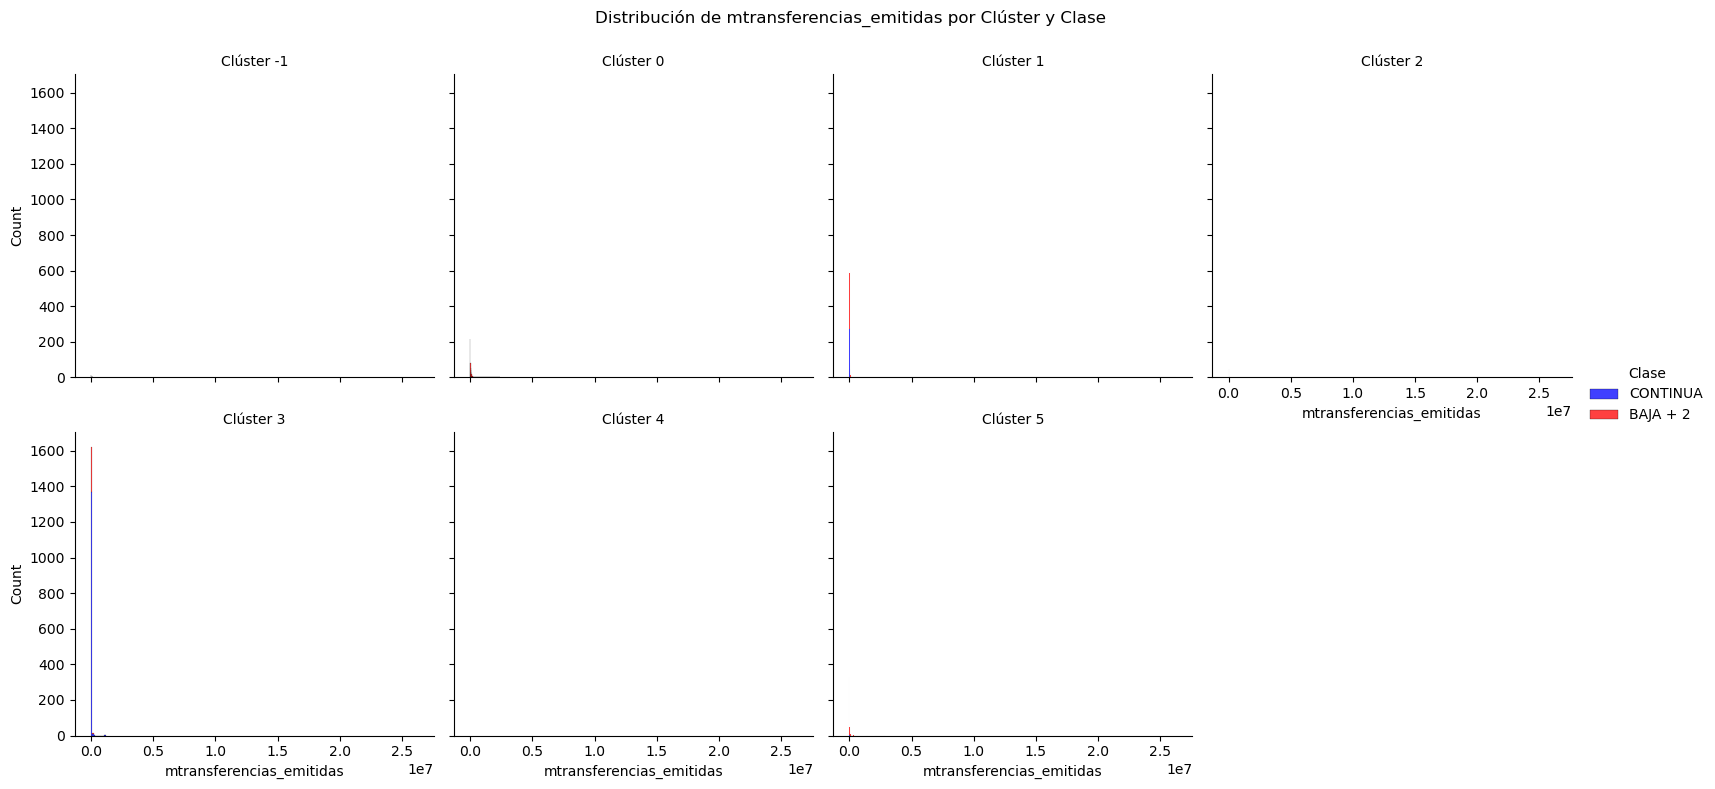

c:\Users\Admin\.conda\envs\datascience\Lib\site-packages\seaborn\axisgrid.py:186: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


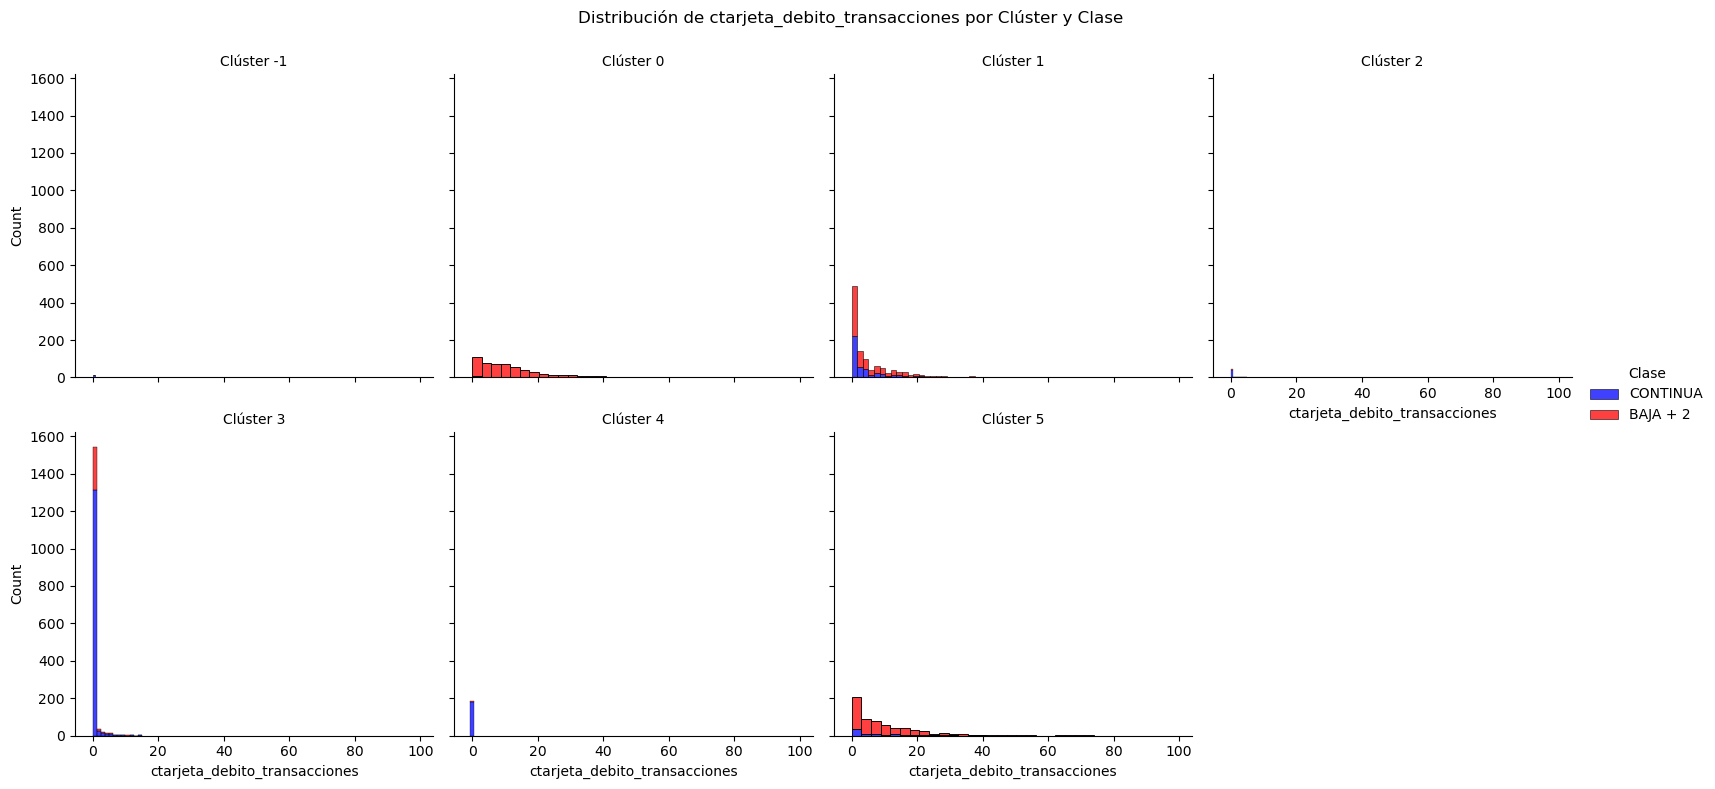

In [46]:
# Crear DataFrame final
Xtrain_rf_imp_df = pd.DataFrame(
    Xtrain_rf_imp,
    index=Xtrain_rf.index,
    columns=Xtrain_rf.columns
)

df_clustered = Xtrain_rf_imp_df.copy()
df_clustered['class_label'] = ytrain_rf
df_clustered['cluster'] = y.labels_

# Variables a analizar
variables = ['ctrx_quarter','mautoservicio','mpayroll','mtransferencias_emitidas','ctarjeta_debito_transacciones'] 

# Visualización
for var in variables:
    g = sns.FacetGrid(df_clustered, col='cluster', height=4, col_wrap=4)
    g.map_dataframe(
        sns.histplot,
        x=var,
        hue='class_label',
        multiple='stack',
        palette={0: 'red', 1: 'blue'}
    )
    g.add_legend(title='Clase', labels=['CONTINUA', 'BAJA + 2'])
    g.set_titles('Clúster {col_name}')
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Distribución de {var} por Clúster y Clase')
    plt.show()

<Axes: xlabel='cluster'>

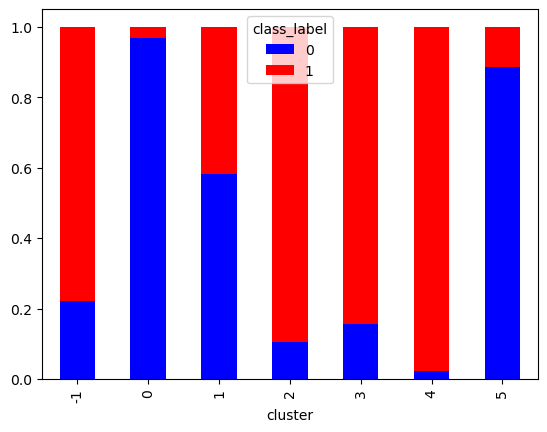

In [33]:
df_clustered.groupby('cluster')['class_label'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, color=['blue', 'red'])

In [54]:
# ctrx_quarter  - mautoservicio  - mpayroll  - mtransferencias_emitidas  - ctarjeta_debito_transacciones

df_clustered.groupby('cluster').agg(Cantidad_de_transacciones=('ctrx_quarter', 'mean')\
    , Max_cantidad_transacciones=('ctrx_quarter', 'max'), Mean_m_payroll=('mpayroll', 'mean')\
        , Max_m_payroll=('mpayroll', 'max'), Mean_m_transferencias_emitidas=('mtransferencias_emitidas', 'mean')\
            , Max_m_transferencias_emitidas=('mtransferencias_emitidas', 'max'), Mean_ctarjeta_debito_transacciones=('ctarjeta_debito_transacciones', 'mean')).reset_index().style.background_gradient(cmap='viridis')

,cluster,Cantidad_de_transacciones,Max_cantidad_transacciones,Mean_m_payroll,Max_m_payroll,Mean_m_transferencias_emitidas,Max_m_transferencias_emitidas,Mean_ctarjeta_debito_transacciones
0,-1,37.833333,127.000000,9597.059444,133591.700000,13645.486667,140225.110000,3.166667
1,0,152.295956,442.000000,161296.338805,6517531.680000,61552.925331,2360076.000000,11.928309
2,1,127.211849,1348.000000,18.321418,7856.630000,111269.812576,26272756.880000,6.073609
3,2,9.729167,45.000000,0.000000,0.000000,3304.448958,156736.750000,0.145833
4,3,16.605488,48.000000,765.823220,581717.670000,4727.799537,1219920.000000,0.271341
5,4,2.978495,21.000000,31.532258,5865.000000,0.000000,0.000000,0.000000
6,5,106.193291,512.000000,99707.990367,1158924.000000,34413.017013,2867515.800000,9.685304


In [32]:
df_clustered.columns

Index(['numero_de_cliente', 'foto_mes', 'active_quarter', 'cliente_vip',
       'internet', 'cliente_edad', 'cliente_antiguedad', 'mrentabilidad',
       'mrentabilidad_annual', 'mcomisiones',
       ...
       'Visa_cconsumos', 'Visa_cadelantosefectivo', 'Visa_mpagominimo',
       'intensidad_gasto', 't_saldo_total', 't_consumo_total', 'T_Visa_normal',
       'T_Master_normal', 'class_label', 'cluster'],
      dtype='object', length=161)

## Modelo

In [28]:

X = df_train[df_train['foto_mes'] <= 202104]

y = X['clase_ternaria']

X = X.drop(columns=['clase_ternaria'])

y_pred = df_train[df_train['foto_mes']==202106]
y_pred = y_pred['clase_ternaria']

ganancia_acierto = 273000
costo_estimulo = 7000

mes_train = 202102
mes_test = 202104

In [29]:
"""FUNCIONES VARIAS"""

def ganancia(model, X, y, prop=1, threshold=0.025):

  class_index = np.where(model.classes_ == "BAJA+2")[0][0]
  y_hat = model.predict_proba(X)

  @np.vectorize
  def ganancia_row(predicted, actual, threshold=0.025):
    return  (predicted >= threshold) * (ganancia_acierto if actual == "BAJA+2" else -costo_estimulo)

  return ganancia_row(y_hat[:,class_index], y).sum() / prop

sss = StratifiedShuffleSplit(n_splits=20,
                             test_size=0.3,
                             random_state=668)

# Función que paraleliza la construcción de árboles de decisión
def train_and_evaluate(train_index, test_index, params, X, y):
  m = DecisionTreeClassifier()
  m.fit(X.iloc[train_index],y.iloc[train_index])
  # Note que con el parámetro prop se corrige la distorsión por sampleo de la
  # ganancia
  ganancia_value = ganancia(m, X.iloc[test_index], y.iloc[test_index], prop=0.3)
  return m, ganancia_value


parametros_modelo = {"criterion": 'gini',
                     "random_state":668,
                     "min_samples_split":80,
                     "max_depth":5,
}

results_base = Parallel(n_jobs=-1)(
    delayed(train_and_evaluate)(train_index, test_index, parametros_modelo, X, y)
    for train_index, test_index in sss.split(X, y)
)




In [30]:

sss_opt = ShuffleSplit(n_splits=5, test_size=0.3, random_state=semillas[1])

def objective(trial, X, y, sss):
  criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
  max_depth = trial.suggest_int('max_depth', 2, 20)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 200)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
  max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 20)

  def train_and_evaluate(train_index, test_index, X, y):
    m = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_leaf_nodes=max_leaf_nodes,
        random_state=semillas[0],
    )
    m.fit(X.iloc[train_index],y.iloc[train_index])
    ganancia_value = ganancia(m, X.iloc[test_index], y.iloc[test_index], prop=0.3)
    return ganancia_value

  results = Parallel(n_jobs=-1)(
      delayed(train_and_evaluate)(train_index, test_index, X, y)
      for train_index, test_index in sss.split(X)
  )

  return np.mean(results)

storage_name = "sqlite:///C:/Users/Admin/Documents/1_Notebook/1_Estudio/1 UBA Maestría DS/1_Especialización/1_Segundo Semestre/DMEyF/Python/Optuna/optimization_tree.db"
study_name = "exp_101_decision-tree-opt_02"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

study.optimize(lambda trial: objective(trial, X, y, sss_opt), n_trials=100)




[I 2024-09-16 13:22:44,850] Using an existing study with name 'exp_101_decision-tree-opt_02' instead of creating a new one.
[I 2024-09-16 13:23:23,014] Trial 100 finished with value: 350298666.6666667 and parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 98, 'min_samples_leaf': 1, 'max_leaf_nodes': 20}. Best is trial 12 with value: 350298666.6666667.
[I 2024-09-16 13:24:01,137] Trial 101 finished with value: 350298666.6666667 and parameters: {'criterion': 'entropy', 'max_depth': 14, 'min_samples_split': 146, 'min_samples_leaf': 3, 'max_leaf_nodes': 20}. Best is trial 12 with value: 350298666.6666667.
[I 2024-09-16 13:24:38,712] Trial 102 finished with value: 350298666.6666667 and parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 156, 'min_samples_leaf': 2, 'max_leaf_nodes': 20}. Best is trial 12 with value: 350298666.6666667.
[I 2024-09-16 13:25:15,955] Trial 103 finished with value: 349738666.6666667 and parameters: {'criterion': 'entr

KeyboardInterrupt: 

In [178]:
optuna.visualization.plot_optimization_history(study)

In [161]:
plot_slice(study)

In [162]:
plot_contour(study)

In [163]:
plot_contour(study, params=["max_depth", "max_leaf_nodes"])

### Variables más importantes

In [164]:
df_train.shape

(981946, 165)

In [179]:
# Obtener el mejor modelo
best_trial = study.best_trial
best_model_params = best_trial.params
print("Mejor modelo:", best_model_params)

model_best = DecisionTreeClassifier(**best_model_params, random_state=semillas[0])
model_best.fit(X, y)

importancias_model_best = model_best.feature_importances_

importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importancias_model_best
}).sort_values(by='importance', ascending=False)


print(f"Ganancia del mejor modelo: {ganancia(model_best, X, y)}")

importances_df.style.background_gradient(cmap='coolwarm')
pd.set_option('display.max_rows', 10)


Mejor modelo: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 191, 'min_samples_leaf': 6, 'max_leaf_nodes': 20}
Ganancia del mejor modelo: 342720000.0


### Predicción 

In [180]:
dtrain = df_train[df_train['foto_mes'] <= 202104]
dapply = df_train[df_train['foto_mes'] == 202106]


X_train = dtrain.drop(columns=['clase_ternaria'])
y_train = dtrain['clase_ternaria']
X_apply = dapply.drop(columns=['clase_ternaria'])


prediccion = model_best.predict_proba(X_apply)


prediccion_df = pd.DataFrame(prediccion, columns=model_best.classes_, index=X_apply.index)


prediccion_df['BAJA+2'] = (prediccion_df['BAJA+2'] > 0.025).astype(int)


df_train.loc[df_train['foto_mes'] == 202106, 'Predicted'] = prediccion_df['BAJA+2']


In [181]:
dapply['Predicted'] = prediccion_df['BAJA+2']

C:\Users\Admin\AppData\Local\Temp\ipykernel_11820\2307290294.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [182]:
resultado = dapply[['numero_de_cliente','Predicted']]
resultado.to_csv(r'C:\Users\Admin\Documents\1_Notebook\1_Estudio\1 UBA Maestría DS\1_Especialización\1_Segundo Semestre\DMEyF\Python\Competencias\Competencia_1\entrega_03.csv', index=False)

### Matriz de Correlación

In [45]:
lista_variables_utiles = importances_df[importances_df['importance'] > 0.01]['feature'].tolist()

<Axes: >

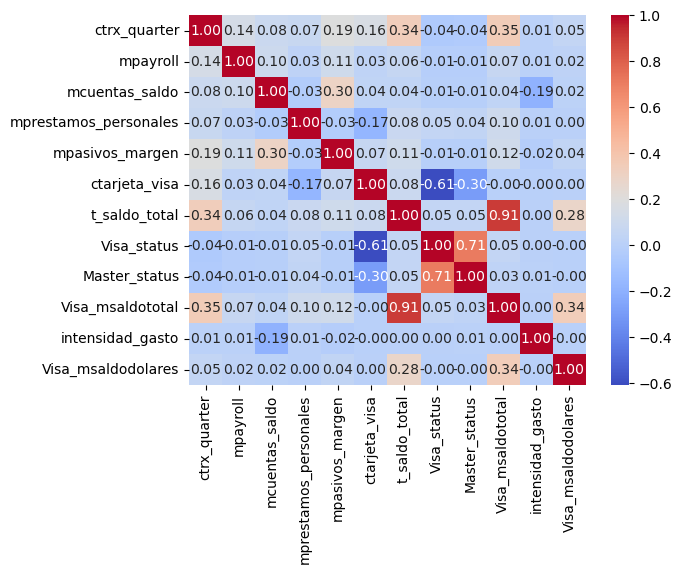

In [46]:
# Analisis de la correlación de Pearson de estas variables

df_train_abril = df_train[df_train['foto_mes'] == 202104]
df_train_abril = df_train.drop(columns=['clase_ternaria'])  
matriz_correlacion_abril = df_train_abril.corr()
matriz_correlacion_abril = matriz_correlacion_abril.loc[lista_variables_utiles, lista_variables_utiles]
sns.heatmap(matriz_correlacion_abril, annot=True, cmap='coolwarm', fmt=".2f")